In [1]:
##########################################
# Import modules, settings for script, import raw data, merge
##########################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

# working directory
str_wd = '/Your/folder/containing/data/files/'

# set RNG seed
int_rngseed = 52423

# List numeric and categorical features. Normally I'd get these from a csv/json that lists all column names
# their dtypes, whether they can be used as features, etc.
lst_features_num = ['age', 'bmi', 'bp', 'gfr', 'acr']
lst_features_cat = ['gender', 'race']

# define the column name of the target
str_target = 'aki'

# set wd
os.chdir(str_wd)

# import raw data
df_ehr = pd.read_csv('aki_data.csv')  
df_claims = pd.read_csv('claims_data.csv')  

# View raw data
# print(df_ehr.head())
# print(df_claims.head())

##########################################
# Merge data
##########################################

# make sure icd column is string type
df_claims['icd'] = df_claims['icd'].astype(str)

# Identify rows in the claims data frame with the ICD codes/comorbidities listed in the instructions
df_claims['icd_htn'] = df_claims['icd'].str.startswith('401').astype(int)
df_claims['icd_dia'] = df_claims['icd'].str.startswith('250').astype(int)
df_claims['icd_chf'] = df_claims['icd'].str.startswith('428').astype(int)

# Group by 'patient_id' and sum the identified conditions, this will aggregate all conditions per patient
df_claims_grouped = df_claims.groupby('patient_id')[['icd_htn', 'icd_dia', 'icd_chf']].sum()

# Merge df_ehr and df_claims_grouped on their ID columns
df_merged = pd.merge(df_ehr, df_claims_grouped, left_on='id', right_on='patient_id', how='left')

print('Size of full dataset after merging:')
print(df_merged.shape)

##########################################

Size of full dataset after merging:
(10000, 12)


In [2]:
##########################################
# Examine Categorical Features
##########################################


##########################################
# frequency tables for categorical columns. Make sure all values make sense and count missing values
for column in lst_features_cat:

    print('#########################')
    print('Freqs for ' + column)
    print(df_merged[column].value_counts(dropna=False))

##########################################

# COMMENTS: Both features have missing values, but instead of trying to infer the ground truth I'm just 
# going to treat missing values for categorical variables as a unique category in this case. This will
# be part of the "baseline" dataset without any fancy imputation methods. Future attempts to deal with 
# these missing values in a better way can then be compared to the baseline pre-processing strategy to 
# see if the fancy methods result in non-trivial performance gains.

##########################################

# one-hot encode these columns. No imputation for missing values, simply give them their own category.
# For datasets with many more categorical columns I'd use sklearn's OneHotEncoder in a preprocessing
# pipeline.
df_merged = pd.get_dummies(df_merged, columns=['gender', 'race'], dummy_na=True)

##########################################

#########################
Freqs for gender
Male      4753
Female    4747
NaN        500
Name: gender, dtype: int64
#########################
Freqs for race
White    5862
Black    1835
Other    1803
NaN       500
Name: race, dtype: int64


In [3]:
##########################################
# Examine Numerical Features
##########################################


##########################################
# Create table for summary stats of numeric variables

# Create an empty df for results
df_feature_summary = pd.DataFrame()

# Loop through the list of columns
for column in lst_features_num:

    # summary stats for features, convert to dataframe, transpose so each row represents 
    # stats for a single feature, round for readability
    feature_summary = df_merged[column].describe().to_frame().transpose().round(2)

    # count missing values
    feature_summary['na'] = df_merged[column].isna().sum()

    # Add the summary statistics to summary dataframe as a new row
    df_feature_summary = pd.concat([df_feature_summary, feature_summary])

# get percent missing values
df_feature_summary['na_pct'] = df_feature_summary['na'] / (df_feature_summary['count'] + df_feature_summary['na'])

print(df_feature_summary)

##########################################

      count    mean    std    min     25%     50%     75%     max   na  na_pct
age  9500.0   58.50  23.51  18.00   38.00   58.00   79.00   99.00  500    0.05
bmi  9500.0   24.95   5.00   7.27   21.55   24.92   28.41   46.61  500    0.05
bp   9500.0  120.01   9.92  78.71  113.31  120.06  126.68  159.83  500    0.05
gfr  9500.0   29.79  15.03 -26.95   19.80   29.91   39.86   91.34  500    0.05
acr  9500.0  150.22  44.99 -28.57  121.09  150.44  180.30  323.53  500    0.05


In [4]:
##########################################

# COMMENTS: Values for age, bmi, and bp appear to be in the range of possible real values.
# That said, there appear to be negative values for gfr and acr. It does not appear that negative
# values are reasonable for these parameters. Will comment more and decide how to handle after
# looking at the histograms (below).
#
# All numeric values are missing exactly 5% 

##########################################

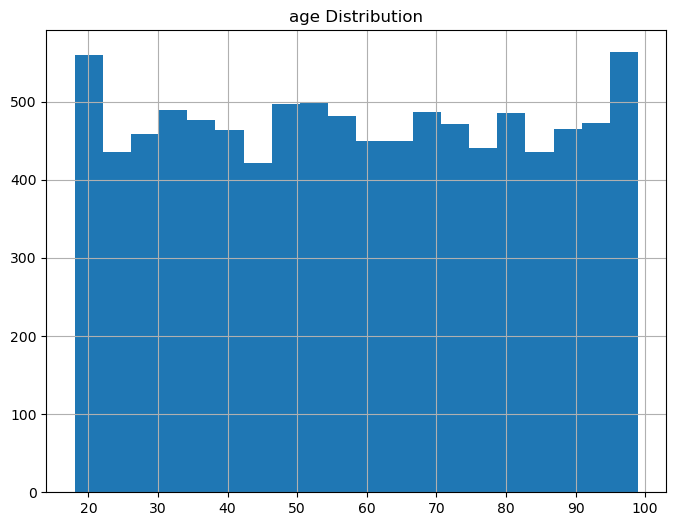

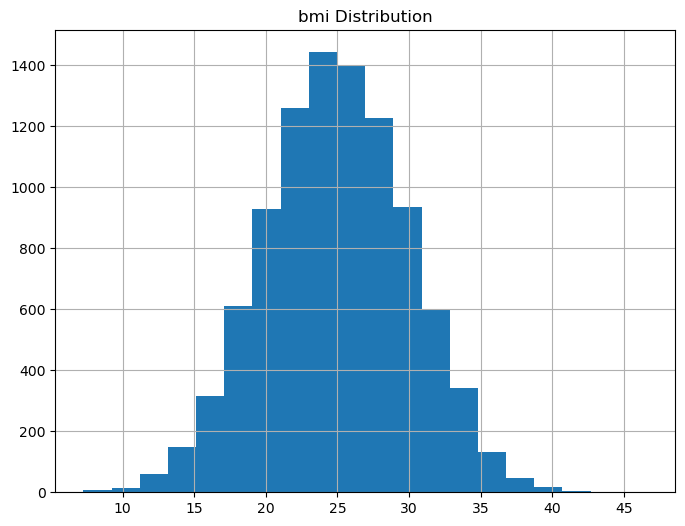

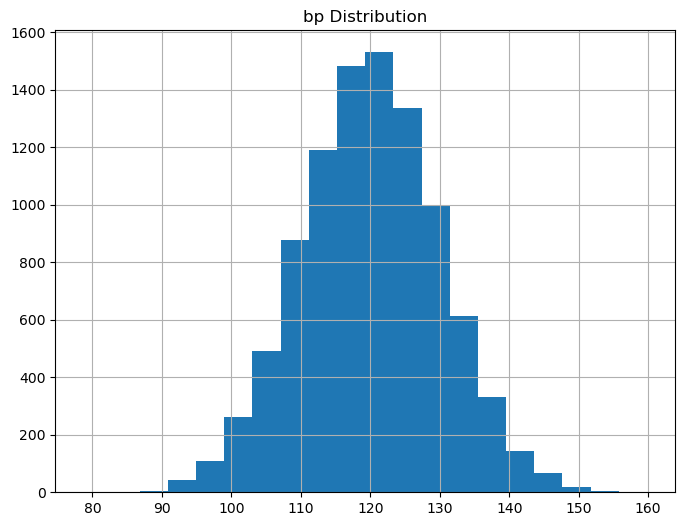

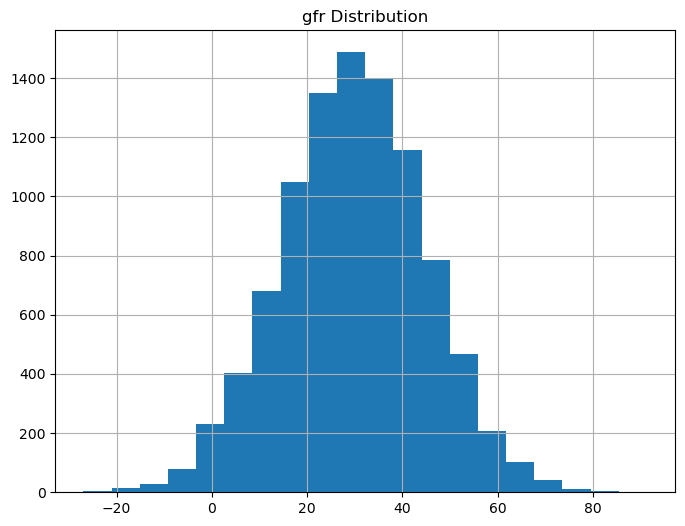

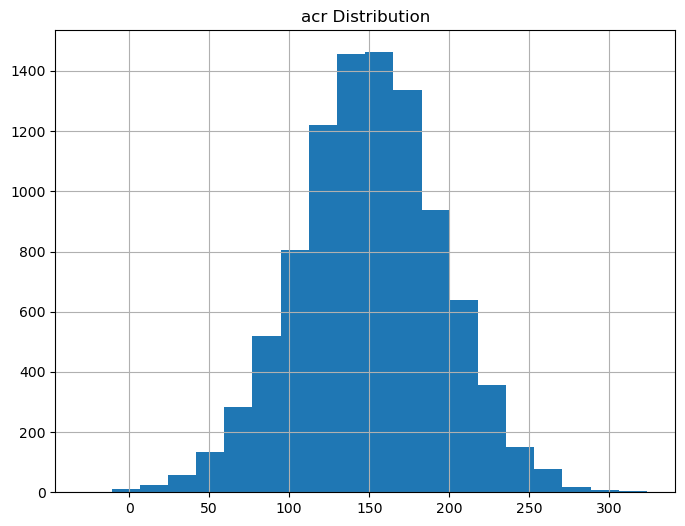

In [5]:
##########################################

# Plot histograms for numeric variables
for column in lst_features_num:
    plt.figure(figsize=(8, 6))
    df_merged[column].hist(bins=20)
    plt.title(f'{column} Distribution')
    plt.show()

##########################################

# Note: Normally I would customize each plot to make sure axis ranges, titles, 
# labels, legends were all appropriate.

##########################################


In [6]:
##########################################

# COMMENTS: Hmmmmmmm. These are all very suspicious. It is as if the
# data were being simulated... 

# The age distribution is far too uniform, especially on the upper end. For example, there are far more 
# people in their 90s than would be expected from any population that wasn't specifically defined 
# by advanced age. The remaining features are all far too close to perfectly normal. The data are clearly
# fabricated for the exercise so for now I'll suspend disbelief, but normally data like this would 
# trigger huge red flags and I'd start doing things like checking for errors in my code, investigating
# how the data was collected, digging into any preprocessing that occured before I got the data, etc.

# Previously I mentioned that reasonable values for gfr and acr should be 0 or positive. Normally I'd look into
# these values more (if possible) and suspect that they were data entry errors. For example, if someone was accidentally
# hitting the "negative" character I'd multiply by -1 to make them positive. I might also just delete all
# observations with negative values if negative values were fairly rare. Finally, I might treat them as missing
# values and rely on imputation methods to deal with these. For now, I'm going to leave them alone and assume
# they are a harmless artifact of the way the data were simulated.

##########################################

In [7]:
##########################################
# Other data checks
##########################################


##########################################
# Check for duplicate rows
print('Number of duplicate rows:', df_merged.duplicated().sum())

##########################################
# Check for duplicate IDs. Not necessarily a problem if present, but
# might indicate that the analysis needs to account for sequential observations of the same individuals
print('Number of duplicate ID numbers:', df_merged['id'].duplicated().sum())

##########################################
# Check for target balance

# Recode target variable
df_merged[str_target] = df_merged[str_target].replace({'Yes': 1, 'No': 0})

# Drop rows with missing target values
df_merged = df_merged.dropna(subset=[str_target])
print('Proportion of positive cases for the target:', df_merged[str_target].mean())

##########################################

Number of duplicate rows: 0
Number of duplicate ID numbers: 0
Proportion of positive cases for the target: 0.26372067648663394


In [8]:
##########################################

# COMMENTS: No duplicate rows or ID numbers found. Entire rows being duplicated
# might signal that I'm creating duplicates somewhere in my code so I'd go back
# and fix that. Sometimes they are already present in the data prior to my analysis
# and will often delete these if I cannot learn about the reason they exist. 
#
# Duplicate ID numbers that have unique values in features might indicate multiple
# observations of the same individual at different points in time. This could influence
# decisions about how the test/validation sets are constructed (e.g., testing only 
# on observations that occur AFTER observations present in the training data), data
# preprocessing (e.g., whether to incorporate some kind of weighting so that individuals with multiple
# observations do not have larger effects on model training than those only appearing once in the data.). 
#
# Target imbalance is not too extreme. It is big enough that it might be worth experimenting with
# methods of accounting for the imbalance (e.g., generating synthetic observations using SMOTE),
# but I would not expect huge gains given the fact that a real claims dataset is likely 
# contain millions of observations. If imbalance were extreme (e.g., positive cases < 1%)
# then more time would be spent experimenting with ways to address imbalance. 

##########################################

In [9]:
##########################################
# Add noise to target
##########################################

###### THIS IS DONE PURELY TO MAKE THIS ANALYSIS MORE INTERESTING ######

# When I train models using the data provided as is, I end up getting models with nearly
# perfect performance on the test set. Usually this means I have a data leakage problem
# but I've spent an inordinate amount of time trying to track down the leakage and can't find it. 
#
# My compromise is that I am assuming the data simulation process created features that are 
# unrealistically predictive of the target. To reduce this, I'm adding noise to the target here
# to make model performance more variable and, therefore, the analysis more interesting. Comment
# out this code block to see what happens to model performance if I do not do this step.

# Of course, data leakage can be insidious, so I am not entirely convinced that I didn't make
# a mistake here! 

# Choose a subset of rows 
rng = np.random.default_rng()
indices_to_change = rng.choice(df_merged.index, size=int(0.4 * len(df_merged)), replace=False)

# randomly set the target for the selected rows to either 1 or 0 with the assigned probabilities
df_merged.loc[indices_to_change, str_target] = np.random.choice([0, 1], p=[0.75, 0.25], size=len(indices_to_change))

##########################################

In [10]:
##########################################
# Split data into training and testing data
##########################################

# Get list of features only. As mentioned previously, this would normally be something I get from
# csv or json file that functions as a "codebook" to describe the columns in a dataset. 
lst_features = df_merged.columns.tolist()
lst_features.remove(str_target)
lst_features.remove('id')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_merged[lst_features], df_merged[str_target], test_size=0.2, random_state=int_rngseed)


##########################################
# Impute missing data
##########################################

# Initialize imputers
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')

# Set which imputer to actually use for the analysis. I think of these as part of the 
# parameter search when building a model. Not only should we search the space of model
# parameters, but we should also search the space of preprocessing strategies. 
imputer_selected = imputer_mean
#imputer_selected = imputer_knn

# Train imputer on training data to avoid data leakage
imputer_selected.fit(X_train)

# Impute missing values on training and test sets
X_train = pd.DataFrame(imputer_selected.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer_selected.transform(X_test), columns=X_test.columns)


##########################################
# Feature engineering: 2-way interactions and polynomials
##########################################

# Normally I'd spend more time on feature engineering, especially if I were working
# with more ICD codes. For example, grouping codes using the Elixhauser comorbidity indices, 
# grouping codes that qualify as valid "causes of death" (for mortality models), purely 
# empirical methods like PCA etc. Here I just add a few 2-way interactions and polynomials. 
# I'm doing this here because I needed to have missing values imputed and I couldn't do that 
# until splitting the data into train and test sets.

# Add interactions
X_train['bp_bmi_itx']  = X_train['bp']  * X_train['bmi']
X_train['gfr_bmi_itx'] = X_train['gfr'] * X_train['bmi']
X_train['gfr_acr_itx'] = X_train['gfr'] * X_train['acr']
X_test['bp_bmi_itx']  = X_test['bp']  * X_test['bmi']
X_test['gfr_bmi_itx'] = X_test['gfr'] * X_test['bmi']
X_test['gfr_acr_itx'] = X_test['gfr'] * X_test['acr']

# Add polynomials
X_train['age_sq'] = X_train['age'] ** 2
X_train['gfr_sq'] = X_train['gfr'] ** 2
X_train['acr_sq'] = X_train['acr'] ** 2
X_test['age_sq'] = X_test['age'] ** 2
X_test['gfr_sq'] = X_test['gfr'] ** 2
X_test['acr_sq'] = X_test['acr'] ** 2


# Update lists of features
lst_features_new = ['bp_bmi_itx', 
                        'gfr_bmi_itx', 
                        'gfr_acr_itx', 
                        'age_sq', 
                        'gfr_sq',
                        'acr_sq']
lst_features_num.extend(lst_features_new)
lst_features.extend(lst_features_new)

##########################################
# Scale numeric features
##########################################
# As with the one-hot encoding performed previously, this step would be included in 
# an sklearn pipeline

# Initialize scalers.
scaler = MinMaxScaler()

# Fit on the training set (for specified columns) and transform both training and test sets
X_train[lst_features_num] = scaler.fit_transform(X_train[lst_features_num])
X_test[lst_features_num] = scaler.transform(X_test[lst_features_num])

# Print shapes of train and test sets
print('Training Set:', X_train.shape)
print('Testing Set:', X_test.shape)

##########################################

Training Set: (7332, 21)
Testing Set: (1833, 21)


In [11]:
##########################################
# Train logistic regression model and search ridge penalties
##########################################

# I choose logistic regression here to serve as a benchmark model. It is the
# one against which I compare other models. The main reason I use it as a benchmark
# is because regression models are simpler and interpretable. Therefore, these kinds
# of models should be preferred if their performance is equal to less interpretable 
# alternatives. In short, I use this as a way of gauging "how good" my truly preferred
# models (XGBoost in this case) are. They can also be used as part of a stacked ensemble.

##########################################
# Train models 

# The parameter search grid here only explores the ridge penalty. I would also
# search over the lasso penalty and l1-l2 ratios (elastic net), but I've found that
# ridge generally gives the best models with very large datasets. If we needed to minimize
# the number of features included in the model then I'd go with lasso. 

# Define the parameter values to search
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Inverse of regularization strength
    'penalty': ['l2'],  # Specify L2 as the penalty for Ridge regression
}

# Create instance of log reg model
log_reg = LogisticRegression(solver='liblinear')

# Initiate the grid
grid_search_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=5)

# Fit models
grid_search_logreg.fit(X_train, y_train)

##########################################
# Model performance

# Print the best parameters
print('Best Parameters:', grid_search_logreg.best_params_)

# Get the best model
best_logreg = grid_search_logreg.best_estimator_

# Predict on test data (classes and probabilities)
y_pred = best_logreg.predict(X_test)
y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds, and aucpr
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

# Calculate and print performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'AUPRC: {auprc:.4f}')

Best Parameters: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.78
Precision: 0.65
Recall: 0.37
F1 Score: 0.47
ROC AUC Score: 0.7863
AUPRC: 0.5708


Accuracy: 0.83
Precision: 0.67
Recall: 0.70
F1 Score: 0.68
ROC AUC: 0.7890
AUPRC: 0.5806


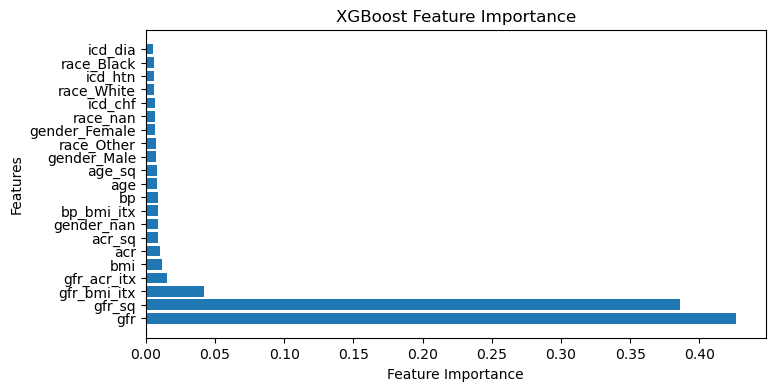

In [12]:
##########################################
# Train xgboost model with grid search over various parameters
##########################################

# I choose XGBoost here because this algorithm (and related ones like LightGBM) tend to do so well
# with tabular data and they train quickly. I always expect this model to perform best with large tabular 
# datasets.

##########################################
# Train models 

# Define the parameter grid for hyperparameter tuning. Normally this would be a more expansive
# search (especially of tree depths) and include more ways to regularize the model (e.g., various 
# sub-sampling rates, L1 and L2 penalties, etc.)

param_grid = {
    'learning_rate': [0.000001,.001],
    'max_depth': [7,],
    'n_estimators': [100, 500],
}

# Initialize xgb classifier and set default parameters 
xgb_clf = XGBClassifier(objective='binary:logistic',
    subsample=0.8,
    colsample_bytree=0.8)

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5)

# Fit models / perform grid search
grid_search.fit(X_train, y_train)

##########################################
# Model performance

# Get best model
best_model = grid_search.best_estimator_

# Predict on test data with best model. Get predicted classes
# as well as predicted probabilities
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds, and aucpr
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

# Calculate and print performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'AUPRC: {auprc:.4f}')

# Get grid search results and store in pandas df
results_df = pd.DataFrame(grid_search.cv_results_)

# Print the results table
# print(results_df)

# Get feature importances
importance_scores = best_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importance scores and feature names
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_scores)), sorted_scores, tick_label=sorted_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()



In [13]:
##########################################
# FINAL COMMENTS
##########################################

# Overall the XGBoost model did not clearly outperform the logistic regression model. The two 
# main metrics I focus on are the ROC_AUC and PR_AUC and XGBoost only did better with PR_AUC.
# If this was a highly imbalanced dataset then I would lean toward using PR_AUC to make a decision, 
# but the difference in PR_AUC is so small that it would be hard to recommend the XGBoost 
# model over the logistic regression model. The main reason I would lean toward logistic regression 
# is because it is only trivially outperformed by XGBoost (0.581 vs 0.571) AND it is far more 
# interpretable than XGBoost. In other words, almost nothing is sacrificed by preferring the 
# simpler model in this scenario. The only case in which I would prefer the XGBoost model with
# results like those shown above is if almost zero value was placed on interpretability.

##########################################